In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Tensor Flow

In [2]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets

print("Tensorflow version" + tf.__version__)

ModuleNotFoundError: No module named 'tensorflow'

* While importing other usefull libraries

In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from matplotlib import cm
import math, re, os
from IPython.display import Image


# Detect Accelerator

In [5]:
try:
    tpu= tf.distribute.cluster_resolver.TPUClusterResolver() # Code for TPU Detection 
    print("Yes running on TPU", tpu.master())
except ValueError:
    tpu = None

In [6]:
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)  #Connect
    tf.tpu.experimental.initialize_tpu_system(tpu)  #Initialize
    strategy= tf.distribute. experimental.TPUStrategy(tpu)
else:
    strategy= tf.distribute.get_strategy() # DEFAULT Distributon in TENSORFLOW (CPU & GPU)
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Data Path

Google Cloud Storage Bucket (GCSB) = Storage for datasets being processed with TPU

In [7]:
#get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started
#GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"


In [8]:
# On TPU VMs, you can use the following path directly
GCS_DS_PATH = '/kaggle/input/tpu-getting-started'

# Parameters

In [9]:
IMAGE_SIZE = [512, 512] 
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE # Read from multiple files
EPOCHS = 30


TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 


Obtain Classes

In [10]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']     

# Load Data

* Need to define a function to read the data that is stored in FILES 

In [37]:
#Reshape for TPU
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) #3 represents color
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)




def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed. #See Note 2.3 above 😀

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files. #See Note 2.2 above 😀
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

# Data Wrangling Pipeline

In [39]:

#Random  Horizontal flippings
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    #More Random Fn For variety
    image= tf.image.random_contrast(image, lower=0.5, upper=1.5)
    #image= tf.image.random_hue(image, max_delta=0.3)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True) #load
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO) # Augment & Map
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048) #Randomness
    dataset = dataset.batch(BATCH_SIZE) #Batch Size
    dataset = dataset.prefetch(AUTO) # prefetch(load) next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

Obtain trained, validated, test data for each file

In [17]:
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


# EDA

Number of data items in each File

In [18]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


> # Graph

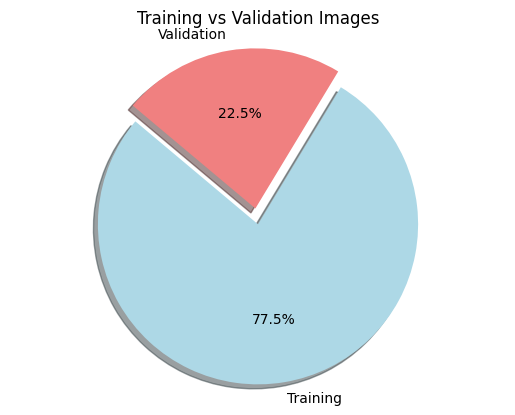

In [19]:
# Define the counts
training_count = NUM_TRAINING_IMAGES
validation_count = NUM_VALIDATION_IMAGES

# Data to plot
labels = ['Training', 'Validation']
sizes = [training_count, validation_count]
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice (Training)

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title
plt.title('Training vs Validation Images')

# Show the pie chart
plt.show()


Dataset contains 7382 unlabeled test images


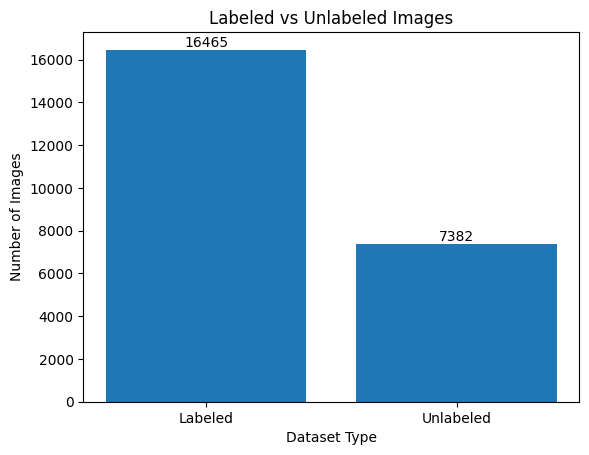

In [20]:
NUM_UNLABELED_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset contains {} unlabeled test images'.format(NUM_UNLABELED_IMAGES))


# Define the counts
labeled_count = NUM_TRAINING_IMAGES + NUM_VALIDATION_IMAGES
unlabeled_count = NUM_UNLABELED_IMAGES

# Create a bar graph
categories = ['Labeled', 'Unlabeled']
counts = [labeled_count, unlabeled_count]

plt.bar(categories, counts)
plt.xlabel('Dataset Type')
plt.ylabel('Number of Images')
plt.title('Labeled vs Unlabeled Images')

# Add text labels at the top of the bars
for i in range(len(categories)):
    plt.text(categories[i], counts[i], str(counts[i]), ha='center', va='bottom')

# Show the bar graph
plt.show()

# Show the bar graph
plt.show()


Color Distribution Histogram of Random 20 images 

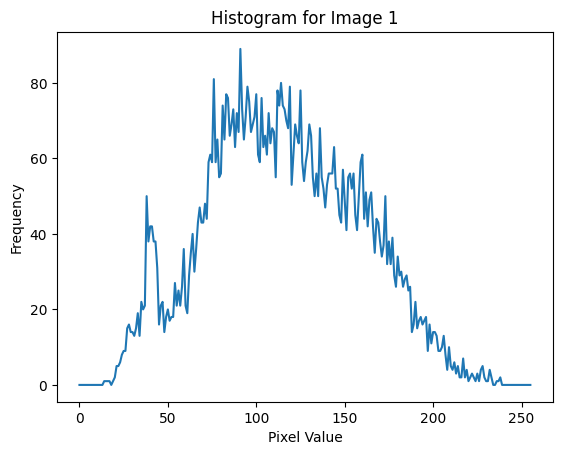

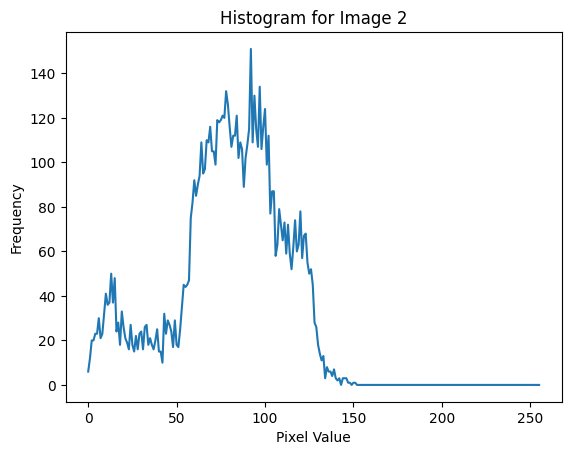

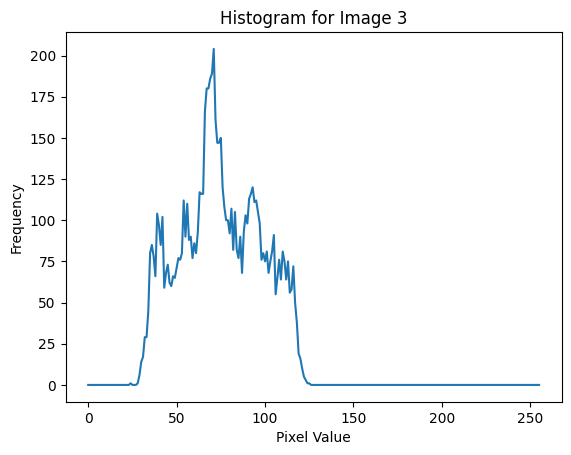

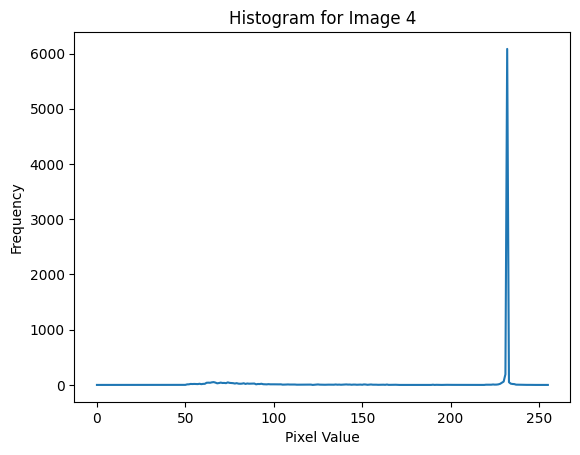

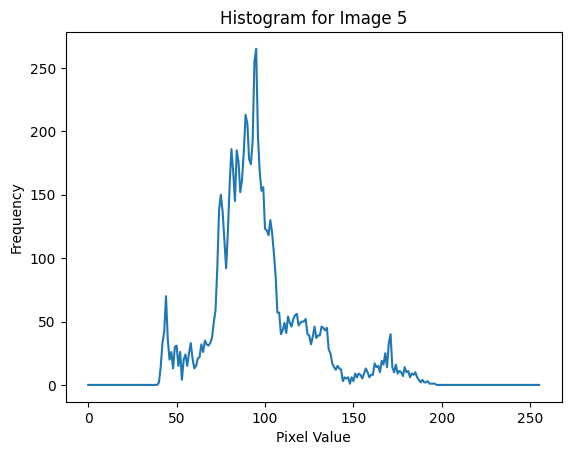

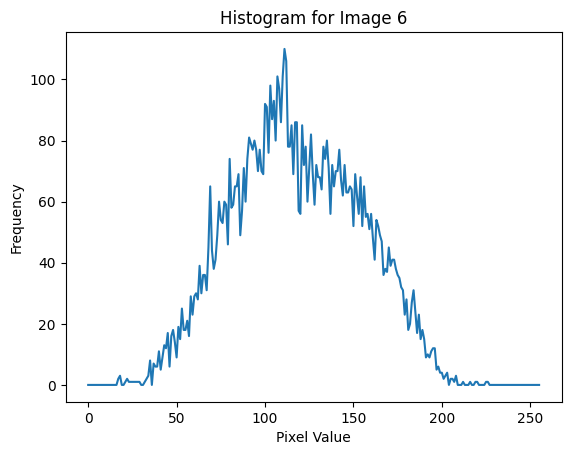

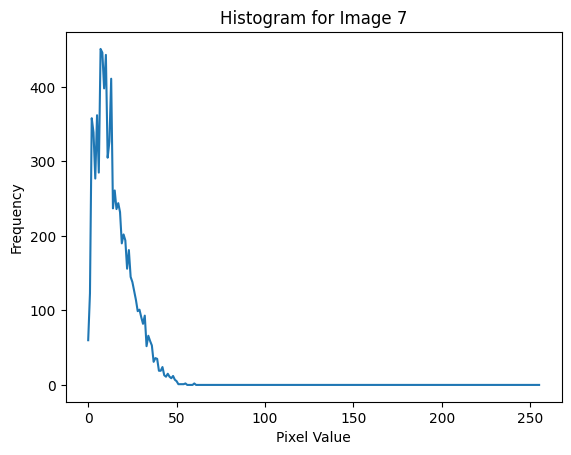

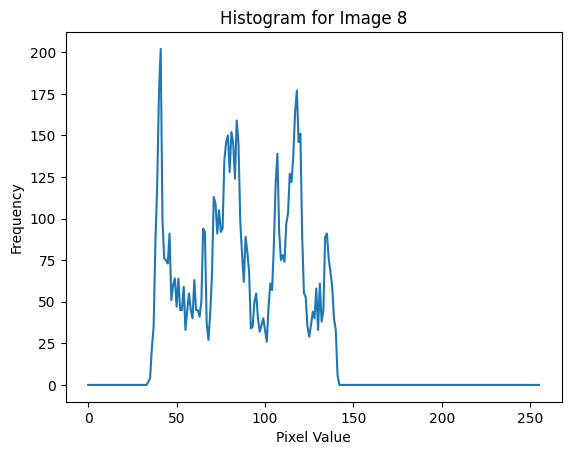

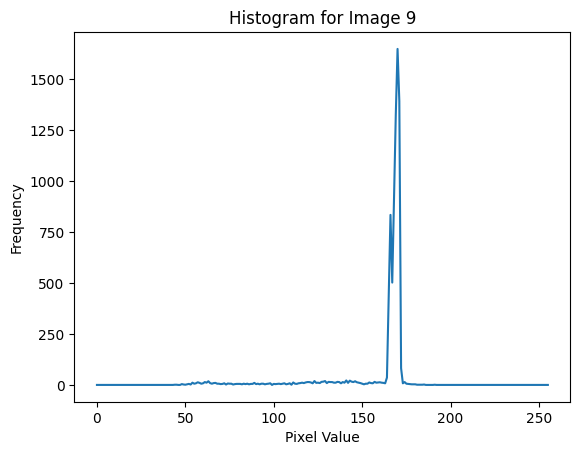

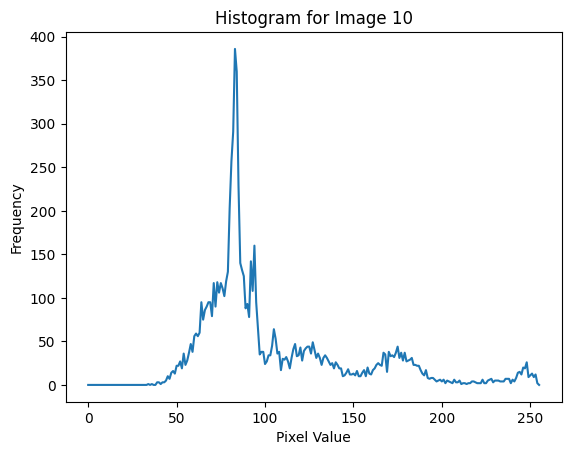

In [34]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Function to convert an image to grayscale and compute its histogram
def compute_histogram(image):
    gray_image = tf.image.rgb_to_grayscale(image)
    gray_image = tf.image.convert_image_dtype(gray_image, tf.uint8)
    histogram = cv2.calcHist([gray_image.numpy()], [0], None, [256], [0, 256])
    return histogram

# Initialize an empty list to store individual histograms
histograms = []

# Process each image in the dataset
for image, label in ds_train.take(10):  # Take the first 20 images
    histogram = compute_histogram(image)
    histograms.append(histogram)

# Plot a separate histogram for each image
for i, histogram in enumerate(histograms):
    plt.figure()
    plt.plot(histogram)
    plt.title(f"Histogram for Image {i + 1}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()


> # Get the SHAPE of the loaded data

In [21]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape) 
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Training data label examples: [67 67 91 ... 50 67  4]


In [22]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape) 
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Test data IDs: ['2a0dc41cd' 'cbb2dd81a' '9f6708c0b' ... '2eb1d2313' '246798d36' 'cd27460a9']


> # View Data

In [23]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
        # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 
                                'OK' if correct else 'NO', 
                                u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, display_mismatches_only=False):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        if display_mismatches_only:
            if predictions[i] != label:
                subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
        else:        
            subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

> #  Display a batch of 20 images

In [24]:
ds_iter = iter(ds_train.unbatch().batch(20))

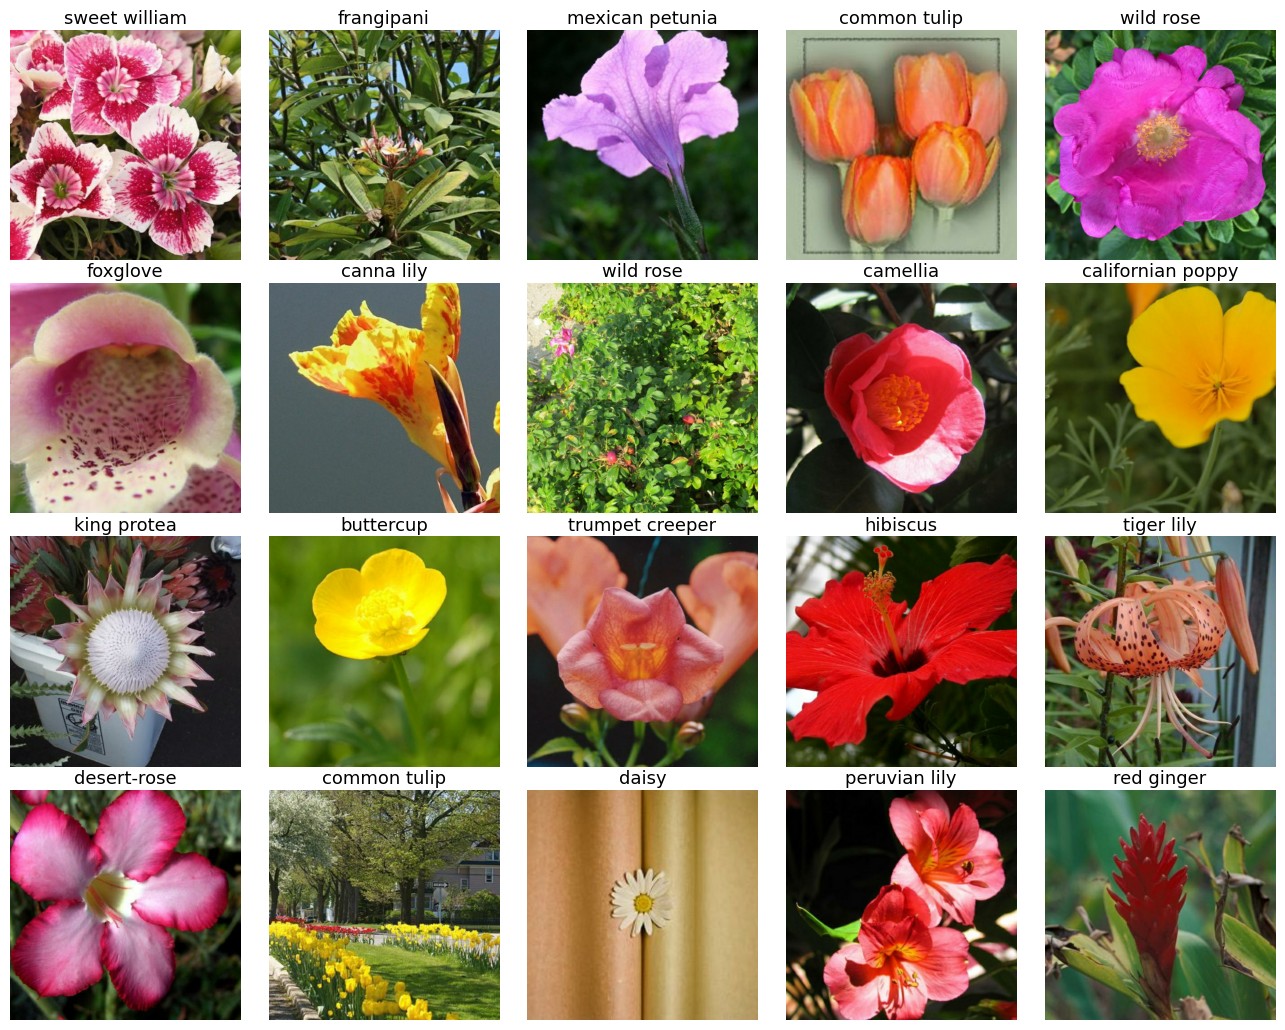

In [25]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

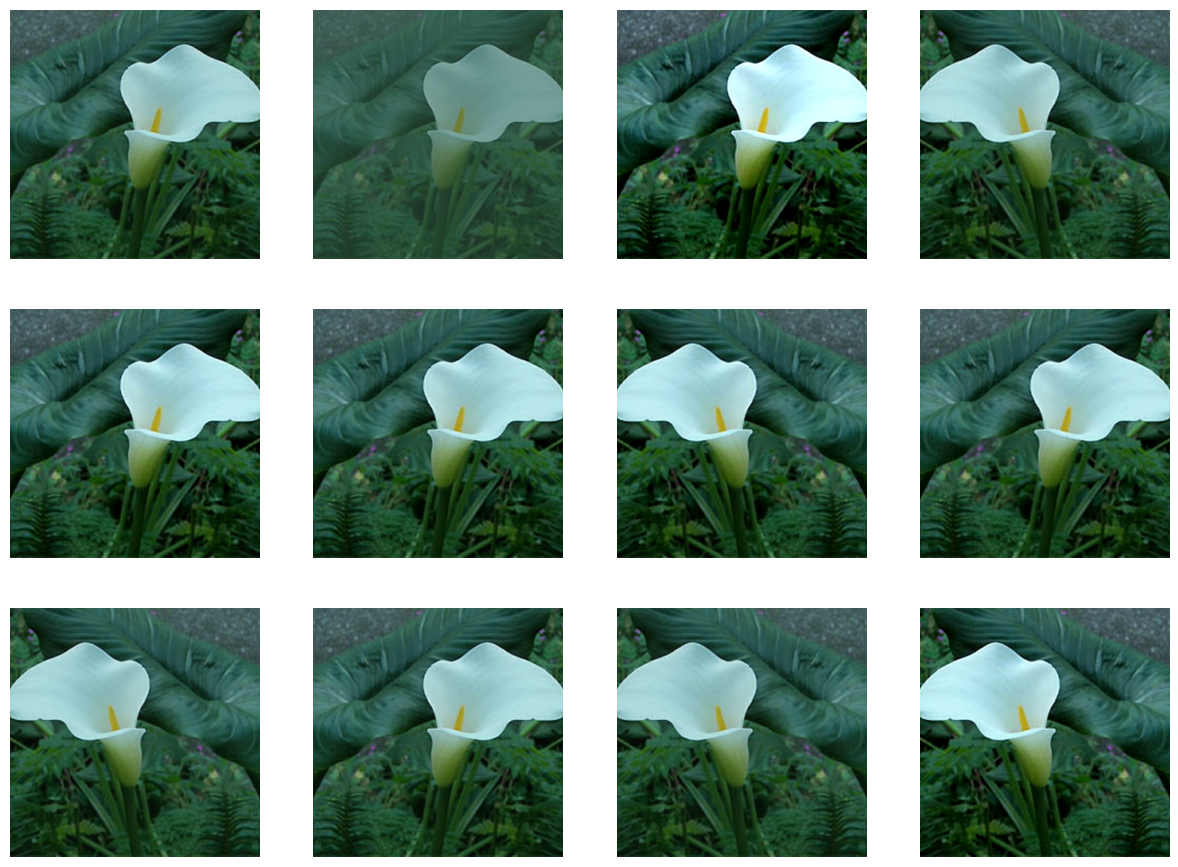

In [40]:
row = 3
col = 4
all_elements = get_training_dataset().unbatch()
one_element = tf.data.Dataset.from_tensors(next(iter(all_elements)))
# Map the images to the data augmentation function for image processing
augmented_element = one_element.repeat().map(data_augment).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

# Build A Model